# Data hypotheses, revisited

The family of models we use here have some fundamental assumptions:

Assumption 1 - there is a positive correlation between post-treatment time and neutrophil count. This means that the neutrophil count will be lowest immediately after treatment, and will tend to recover following the end of treatment. Biologically, this means that ven/aza treatment negatively affects neutrophil count, and that neutrophil count recovers after the end of treatment.

Assumption 2 - there is a negative correlation between blast count and neutrophil count. Biologically, this means that a high level of bone marrow leukemic blasts will negatively affect neutrophil production.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

import sys
sys.path.append('../')

## Load data

In [2]:
# sheet names: Blood_counts, Bone_marrow_blasts, Cycle_days, TLS_lab_C1D2leuk, Annotations
blood_counts = pd.read_excel('../patient_data_venex/Ven_blood_counts_16042023.xlsx', sheet_name='Blood_counts')
bm_blasts = pd.read_excel('../patient_data_venex/Ven_blood_counts_16042023.xlsx', sheet_name='Bone_marrow_blasts')
cycle_days = pd.read_excel('../patient_data_venex/Ven_blood_counts_16042023.xlsx', sheet_name='Cycle_days')

In [3]:
patient_data = pd.read_csv('../patient_data_venex/ven_responses_052023.txt', sep='\t')

## Get hypotheses for all patients

In [4]:
from new_patient_model import extract_data_from_tables_new

### Neutrophil count vs blast count

In [5]:
# TODO: map times between bone marrow blast measurements and blood measurements for the same patient

In [6]:
patient_ids = blood_counts['Pseudonym'].unique()

In [7]:
len(patient_ids)

104

In [8]:
patient_data = {}
patient_data_matched = {}

In [9]:
# interpolate bm_blasts?
import scipy.interpolate

In [10]:
# now, do this for all patients...
neut_blast_correlations = {}
neut_blast_spearman_correlations = {}
for patient_id in patient_ids:
    cycle_info, leuk_table, blast_table = extract_data_from_tables_new(blood_counts,
                                                        bm_blasts, cycle_days, patient_id, use_neut=True)
    patient_data[patient_id] = leuk_table

    if len(leuk_table) <= 2 or len(blast_table) <= 2:
        continue
    # interpolate bone marrow results
    bm_blast_interpolator = scipy.interpolate.PchipInterpolator(blast_table['days_from_bm'], blast_table['bm_blasts'])
    lab_results_matched = leuk_table[leuk_table.days_lab <= blast_table.days_from_bm.max()].copy()
    bm_blasts_interpolated = bm_blast_interpolator(lab_results_matched['days_lab'])
    lab_results_matched['bm_blasts_interpolated'] = bm_blasts_interpolated
    patient_data_matched[patient_id] = lab_results_matched
    correlation = scipy.stats.pearsonr(lab_results_matched['b_neut'], lab_results_matched['bm_blasts_interpolated'])
    neut_blast_correlations[patient_id] = correlation
    neut_blast_spearman_correlations[patient_id] = scipy.stats.spearmanr(lab_results_matched['b_neut'],
                                                                lab_results_matched['bm_blasts_interpolated'])

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



#### Pearson - all patients

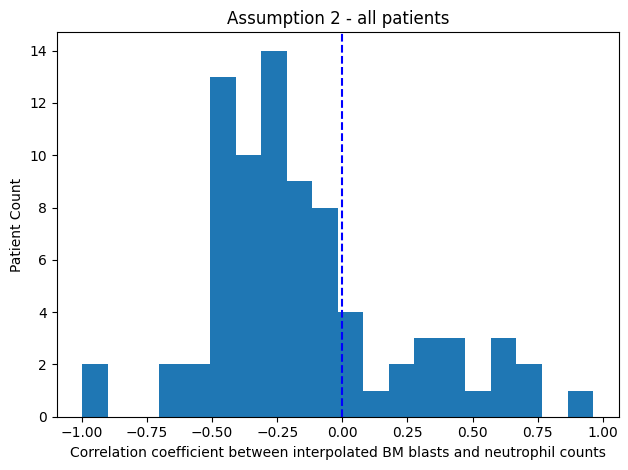

In [11]:
plt.hist([x.statistic for x in neut_blast_correlations.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 2 - all patients')
plt.xlabel('Correlation coefficient between interpolated BM blasts and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [12]:
neut_blast_corr_vals = neut_blast_correlations.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.7439024390243902 of patients
positive correlations:  0.23170731707317074 of patients


In [13]:
# p-value for binomial test of proportion of negative correlations
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=61, n=82, alternative='two-sided', statistic=0.7439024390243902, pvalue=1.1296023055413025e-05)

#### Pearson - >5 points

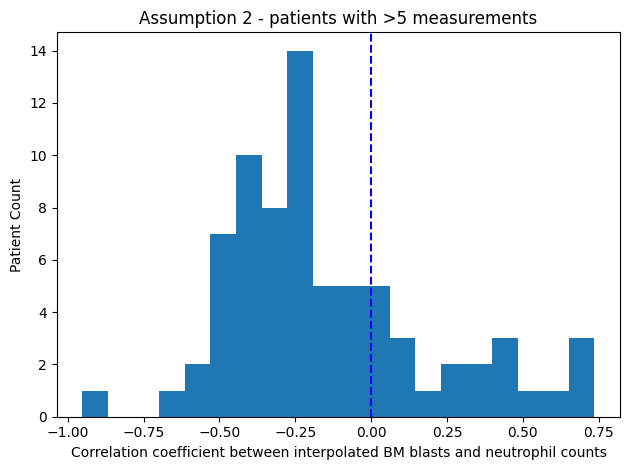

In [14]:
correlation_subset = {pid: x for pid, x in neut_blast_correlations.items() if len(patient_data[pid]) > 5}
plt.hist([x.statistic for x in correlation_subset.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 2 - patients with >5 measurements')
plt.xlabel('Correlation coefficient between interpolated BM blasts and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [15]:
len(correlation_subset)

76

In [16]:
neut_blast_corr_vals = correlation_subset.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.75 of patients
positive correlations:  0.2236842105263158 of patients


In [17]:
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=57, n=76, alternative='two-sided', statistic=0.75, pvalue=1.4836899336372366e-05)

#### Pearson - >= 20 points

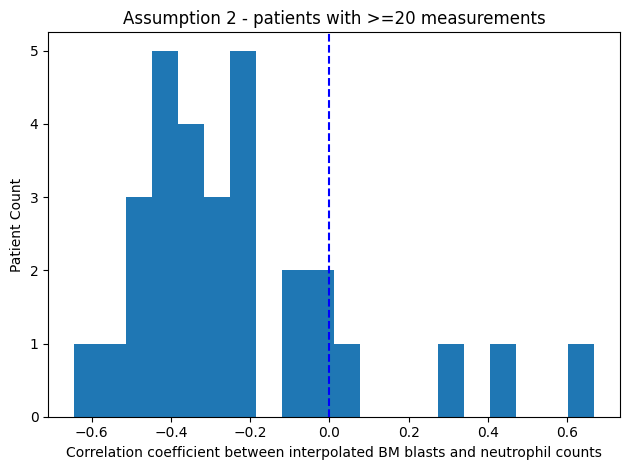

In [18]:
correlation_subset = {pid: x for pid, x in neut_blast_correlations.items() if len(patient_data[pid]) >=20}
plt.hist([x.statistic for x in correlation_subset.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 2 - patients with >=20 measurements')
plt.xlabel('Correlation coefficient between interpolated BM blasts and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [19]:
len(correlation_subset)

32

In [20]:
neut_blast_corr_vals = correlation_subset.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.8125 of patients
positive correlations:  0.125 of patients


In [21]:
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=26, n=32, alternative='two-sided', statistic=0.8125, pvalue=0.0005350527353584766)

#### Pearson - p<0.05

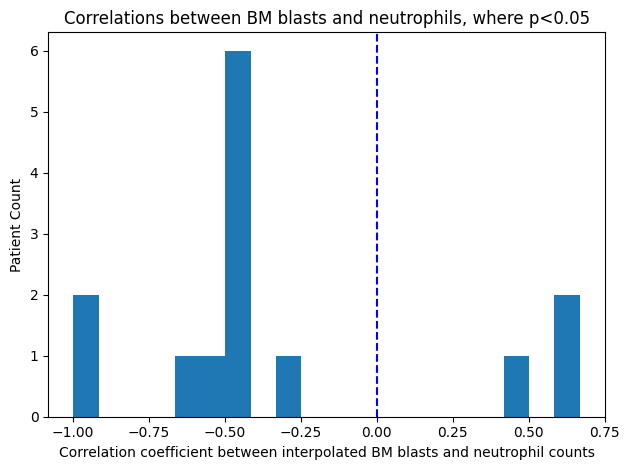

In [22]:
correlation_subset = {pid: x for pid, x in neut_blast_correlations.items() if x.pvalue<0.05}
plt.hist([x.statistic for x in correlation_subset.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Correlations between BM blasts and neutrophils, where p<0.05')
plt.xlabel('Correlation coefficient between interpolated BM blasts and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [23]:
len(correlation_subset)

14

In [24]:
neut_blast_corr_vals = correlation_subset.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.7857142857142857 of patients
positive correlations:  0.21428571428571427 of patients


In [25]:
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=11, n=14, alternative='two-sided', statistic=0.7857142857142857, pvalue=0.057373046875)

#### Spearman - all patients

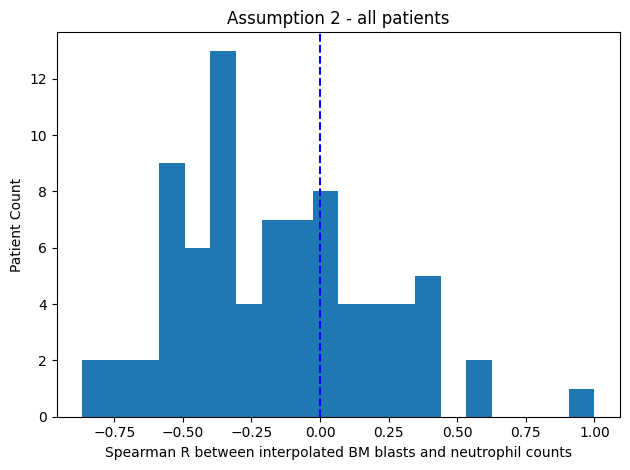

In [26]:
plt.hist([x.statistic for x in neut_blast_spearman_correlations.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 2 - all patients')
plt.xlabel('Spearman R between interpolated BM blasts and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [27]:
neut_blast_corr_vals = neut_blast_correlations.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.7439024390243902 of patients
positive correlations:  0.23170731707317074 of patients


In [28]:
# p-value for binomial test of proportion of negative correlations
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=61, n=82, alternative='two-sided', statistic=0.7439024390243902, pvalue=1.1296023055413025e-05)

#### Spearman - >5 points

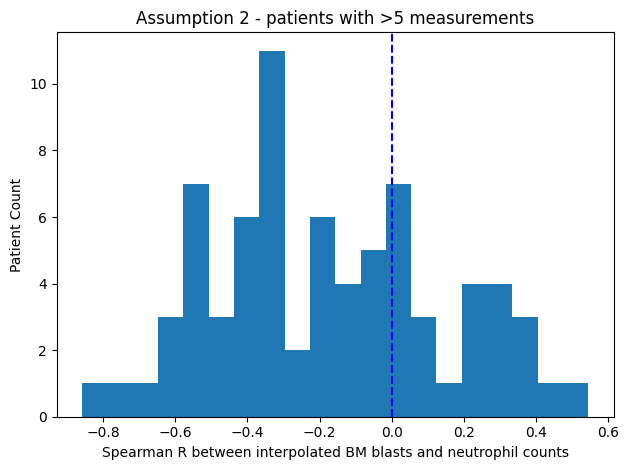

In [29]:
s_correlation_subset = {pid: x for pid, x in neut_blast_spearman_correlations.items() if len(patient_data[pid]) > 5}
plt.hist([x.statistic for x in s_correlation_subset.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 2 - patients with >5 measurements')
plt.xlabel('Spearman R between interpolated BM blasts and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [30]:
neut_blast_corr_vals = s_correlation_subset.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.6973684210526315 of patients
positive correlations:  0.2631578947368421 of patients


In [31]:
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=53, n=76, alternative='two-sided', statistic=0.6973684210526315, pvalue=0.0007645817391550476)

#### Spearman - >= 20 points

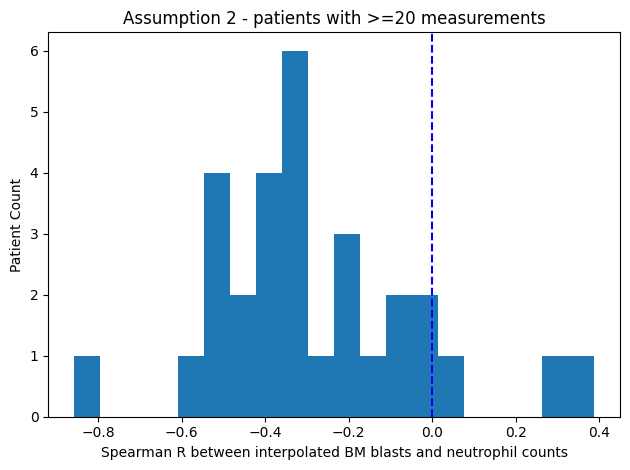

In [32]:
s_correlation_subset = {pid: x for pid, x in neut_blast_spearman_correlations.items() if len(patient_data[pid]) >= 20}
plt.hist([x.statistic for x in s_correlation_subset.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 2 - patients with >=20 measurements')
plt.xlabel('Spearman R between interpolated BM blasts and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [33]:
neut_blast_corr_vals = s_correlation_subset.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.8125 of patients
positive correlations:  0.125 of patients


In [34]:
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=26, n=32, alternative='two-sided', statistic=0.8125, pvalue=0.0005350527353584766)

#### Spearman - p<0.05

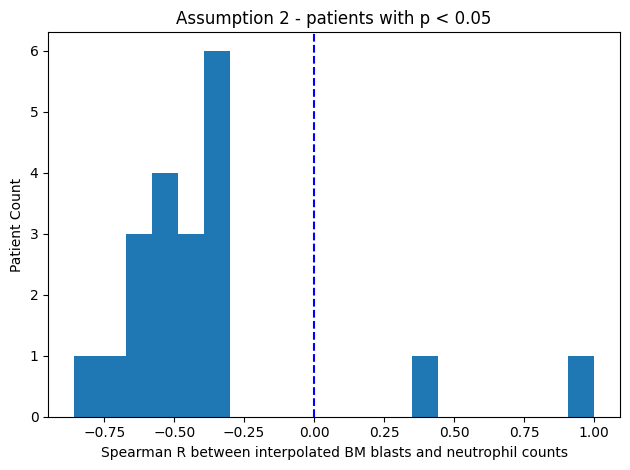

In [35]:
s_correlation_subset = {pid: x for pid, x in neut_blast_spearman_correlations.items() if x.pvalue < 0.05}
plt.hist([x.statistic for x in s_correlation_subset.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 2 - patients with p < 0.05')
plt.xlabel('Spearman R between interpolated BM blasts and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [36]:
neut_blast_corr_vals = s_correlation_subset.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.9 of patients
positive correlations:  0.1 of patients


In [37]:
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=18, n=20, alternative='two-sided', statistic=0.9, pvalue=0.0004024505615234375)

In [38]:
print(neut_blast_corr_vals)

dict_values([SignificanceResult(statistic=-0.5247525024908248, pvalue=0.0070780029884424354), SignificanceResult(statistic=-0.34686649345273207, pvalue=0.02441777631629237), SignificanceResult(statistic=-0.4458978207943051, pvalue=0.0014916517147104918), SignificanceResult(statistic=-0.5796951885499024, pvalue=0.03784464645268356), SignificanceResult(statistic=-0.3361509957806553, pvalue=0.015877228947130936), SignificanceResult(statistic=-0.5420493789363714, pvalue=0.009162140367121244), SignificanceResult(statistic=-0.3213972969215986, pvalue=0.01572077864659795), SignificanceResult(statistic=1.0, pvalue=0.0), SignificanceResult(statistic=-0.7192186269636924, pvalue=0.0007681904189507868), SignificanceResult(statistic=-0.5980609205722571, pvalue=0.011217376736646273), SignificanceResult(statistic=-0.3845015693772062, pvalue=0.017149454004391145), SignificanceResult(statistic=-0.3778402855660821, pvalue=0.016227576541635477), SignificanceResult(statistic=-0.341694946292105, pvalue=0.0

In these graphs, each bar-step is a patient, indicating the correlation between bone marrow blast count (interpolated) and neutrophil count for that patient.

Interpolation was done using the "PCHIP 1-D monotonic cubic interpolation" from scikit-learn - for all control points, the interpolated and actual values are the same.

#### Conclusions:

- Neutrophil counts and bone marrow blast counts are inversely correlated. This indicates some negative effect of blasts on neutrophil production.
- We don't know the time scale of this relationship... maybe it's a lagged relationship?
- Thus, we expect higher bm blasts to inhibit neutrophil production for most patients. This possibly supercedes the known inhibitory effect of venetoclax on neutrophil production.
- Spearman correlations are more negative than Pearson correlations across different data counts
- Among the "significant" correlations, there were some that had significantly positive correlations, which is not what we expect. In these cases, are the blasts less inhibitory towards healthy blood cell production?

TODO:

- ~~correlation between time-since-treatment and neutrophil count?~~ - done
- Can we predict neutrophil count based on a multiple regression of interpolated blast count and time-since-treatment?

### Neutrophil count vs treatment time

How do neutrophil count vary with last treatment time? Hypothesis: we expect longer time since treatment to correspond to higher neutrophil counts, so we expect a positive correlation between time-since-treatment and neutrophil count. This is because with more time after treatment, there is more time for the neutrophil count to recover after decreasing during the treatment cycle.

In [39]:
# now, do this for all patients...
neut_treatment_correlations = {}
neut_treatment_spearman_correlations = {}
neut_treatment_matched = {}
for patient_id in patient_ids:
    cycle_info, leuk_table, blast_table = extract_data_from_tables_new(blood_counts,
                                                        bm_blasts, cycle_days, patient_id, use_neut=True)

    cycle_end_dates = []
    for i, row in leuk_table.iterrows():
        past_cycles = cycle_info[(cycle_info['days_ven_start'] < row['days_lab'])].sort_values('days_ven_stop')
        if len(past_cycles) > 0:
            past_cycles = past_cycles.reset_index()
            last_cycle = past_cycles.iloc[-1]
            last_end_date = last_cycle.days_ven_stop
            cycle_end_dates.append(last_end_date)
        else:
            cycle_end_dates.append(0)

    if len(leuk_table) <= 2 or len(blast_table) <= 2:
        continue

    # match lab results to cycle end dates
    # TODO: what if the lab measurement time is in the middle of a cycle???
    # maybe in that case we should just remove the data point? oh wait, it's already removed...
    lab_results_cycles = leuk_table.copy()
    lab_results_cycles['cycle_end_dates'] = cycle_end_dates
    # remove cycle end dates that are 0
    lab_results_cycles = lab_results_cycles[lab_results_cycles['cycle_end_dates'] > 0]
    lab_results_cycles['time_after_cycle'] = lab_results_cycles['days_lab'] - lab_results_cycles['cycle_end_dates']
    # remove points that are within cycles
    lab_results_cycles = lab_results_cycles[lab_results_cycles['time_after_cycle'] > 0]
    if len(lab_results_cycles) < 2:
        continue
    neut_treatment_matched[patient_id] = lab_results_cycles

    correlation = scipy.stats.pearsonr(lab_results_cycles['b_neut'], lab_results_cycles['time_after_cycle'])
    neut_treatment_correlations[patient_id] = correlation
    neut_treatment_spearman_correlations[patient_id] = scipy.stats.spearmanr(lab_results_cycles['b_neut'],
                                                                lab_results_cycles['time_after_cycle'])

#### Pearson - all patients

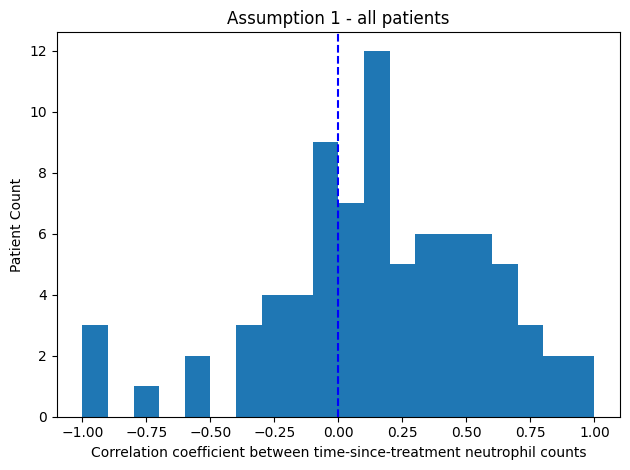

In [40]:
plt.hist([x.statistic for x in neut_treatment_correlations.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 1 - all patients')
plt.xlabel('Correlation coefficient between time-since-treatment neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [41]:
neut_blast_corr_vals = neut_treatment_correlations.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.325 of patients
positive correlations:  0.675 of patients


In [42]:
# p-value for binomial test of proportion of negative correlations
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=26, n=80, alternative='two-sided', statistic=0.325, pvalue=0.002324541288088704)

#### Pearson - >5 patients

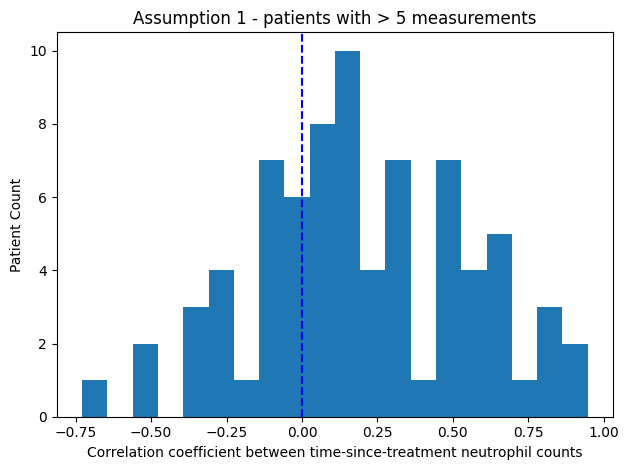

In [43]:
correlation_subset = {pid: x for pid, x in neut_treatment_correlations.items() if len(patient_data[pid]) > 5}
plt.hist([x.statistic for x in correlation_subset.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 1 - patients with > 5 measurements')
plt.xlabel('Correlation coefficient between time-since-treatment neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [44]:
neut_blast_corr_vals = correlation_subset.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.3026315789473684 of patients
positive correlations:  0.6973684210526315 of patients


In [45]:
# p-value for binomial test of proportion of negative correlations
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=23, n=76, alternative='two-sided', statistic=0.3026315789473684, pvalue=0.0007645817391550476)

#### Pearson - >=20 points

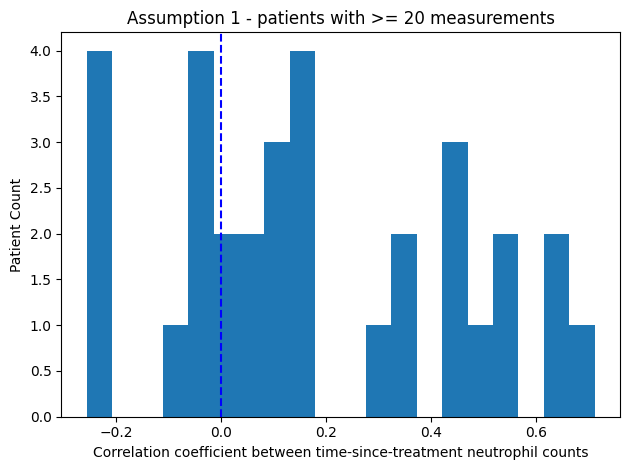

In [46]:
correlation_subset = {pid: x for pid, x in neut_treatment_correlations.items() if len(patient_data[pid]) >= 20}
plt.hist([x.statistic for x in correlation_subset.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 1 - patients with >= 20 measurements')
plt.xlabel('Correlation coefficient between time-since-treatment neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [47]:
neut_blast_corr_vals = correlation_subset.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.28125 of patients
positive correlations:  0.71875 of patients


In [48]:
# p-value for binomial test of proportion of negative correlations
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=9, n=32, alternative='two-sided', statistic=0.28125, pvalue=0.020061607006937265)

#### Pearson - p<0.05 only

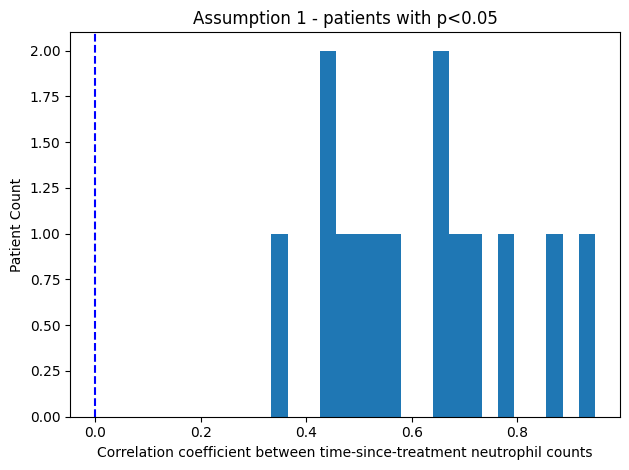

In [49]:
correlation_subset = {pid: x for pid, x in neut_treatment_correlations.items() if x.pvalue<0.05}
plt.hist([x.statistic for x in correlation_subset.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 1 - patients with p<0.05')
plt.xlabel('Correlation coefficient between time-since-treatment neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [50]:
neut_blast_corr_vals = correlation_subset.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.0 of patients
positive correlations:  1.0 of patients


In [51]:
# p-value for binomial test of proportion of negative correlations
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=0, n=14, alternative='two-sided', statistic=0.0, pvalue=0.0001220703125)

#### Spearman - all patients

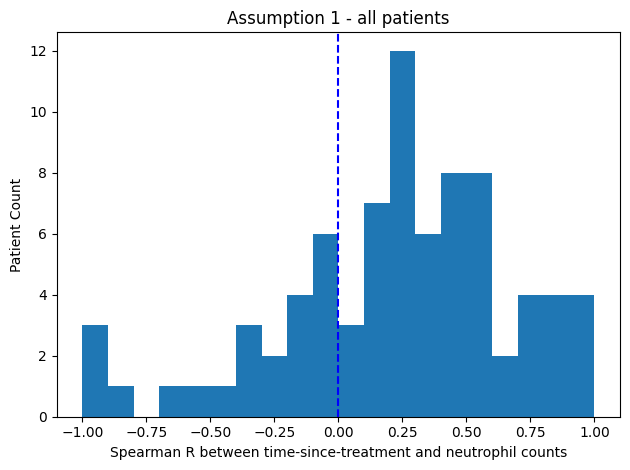

In [52]:
plt.hist([x.statistic for x in neut_treatment_spearman_correlations.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 1 - all patients')
plt.xlabel('Spearman R between time-since-treatment and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [53]:
neut_blast_corr_vals = neut_treatment_spearman_correlations.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.2625 of patients
positive correlations:  0.725 of patients


In [54]:
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=21, n=80, alternative='two-sided', statistic=0.2625, pvalue=2.5291102564670602e-05)

#### Spearman - >5 points

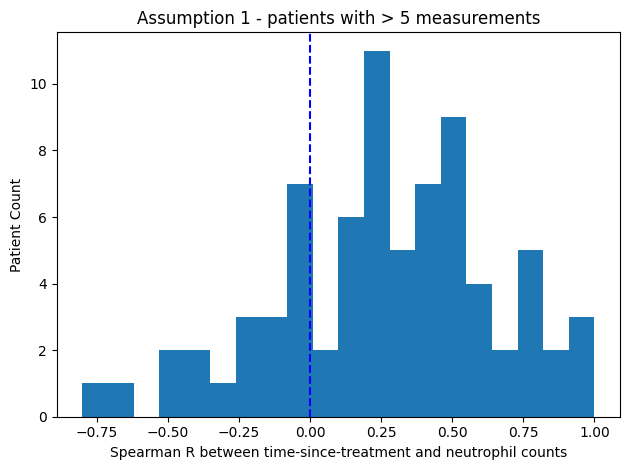

In [55]:
s_correlation_subset = {pid: x for pid, x in neut_treatment_spearman_correlations.items() if len(patient_data[pid]) > 5}
plt.hist([x.statistic for x in s_correlation_subset.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 1 - patients with > 5 measurements')
plt.xlabel('Spearman R between time-since-treatment and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [56]:
neut_blast_corr_vals = s_correlation_subset.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.23684210526315788 of patients
positive correlations:  0.75 of patients


In [57]:
# p-value for binomial test of proportion of negative correlations
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=18, n=76, alternative='two-sided', statistic=0.23684210526315788, pvalue=4.713242239575157e-06)

#### Spearman - >=20 points

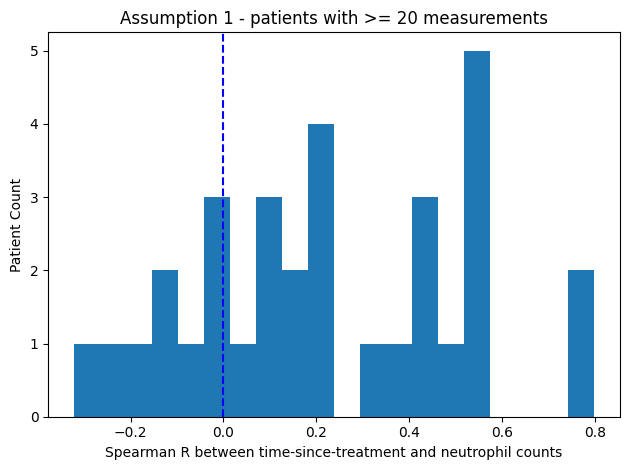

In [58]:
s_correlation_subset = {pid: x for pid, x in neut_treatment_spearman_correlations.items() if len(patient_data[pid]) >= 20}
plt.hist([x.statistic for x in s_correlation_subset.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 1 - patients with >= 20 measurements')
plt.xlabel('Spearman R between time-since-treatment and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [59]:
neut_blast_corr_vals = s_correlation_subset.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.25 of patients
positive correlations:  0.75 of patients


In [60]:
# p-value for binomial test of proportion of negative correlations
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=8, n=32, alternative='two-sided', statistic=0.25, pvalue=0.0070003666914999485)

In [61]:
print(s_correlation_subset)

{8013: SignificanceResult(statistic=-0.23784168879094914, pvalue=0.2630830015429483), 6067: SignificanceResult(statistic=0.0332028256778757, pvalue=0.8388300718907626), 3101: SignificanceResult(statistic=-0.123244565615962, pvalue=0.3938333753209967), 9145: SignificanceResult(statistic=0.46207304448236125, pvalue=0.0007299287942096979), 5157: SignificanceResult(statistic=0.12132480668213931, pvalue=0.6003635839098327), 5161: SignificanceResult(statistic=-0.0572690781144967, pvalue=0.8158596591262528), 8216: SignificanceResult(statistic=0.002825588751164789, pvalue=0.9839794645240962), 8242: SignificanceResult(statistic=0.21955532280226056, pvalue=0.2811786018207369), 9357: SignificanceResult(statistic=0.32507739938080493, pvalue=0.188084781422369), 6416: SignificanceResult(statistic=0.5552839088671836, pvalue=8.919565565411668e-06), 3447: SignificanceResult(statistic=-0.019297842676761455, pvalue=0.9022442066279386), 2467: SignificanceResult(statistic=0.11855978855411226, pvalue=0.4433

#### Spearman - p<0.05 only

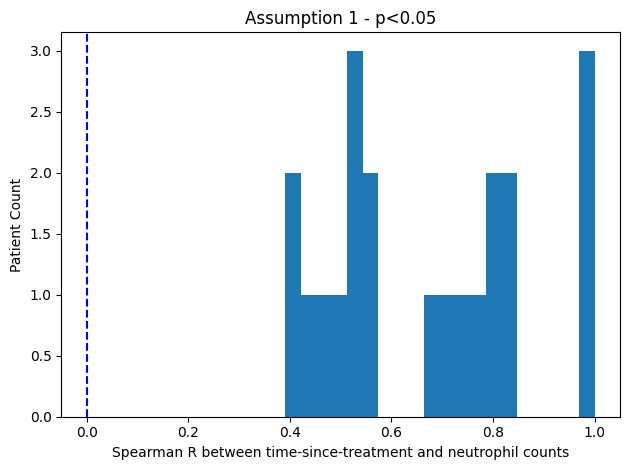

In [62]:
s_correlation_subset = {pid: x for pid, x in neut_treatment_spearman_correlations.items() if x.pvalue < 0.05}
plt.hist([x.statistic for x in s_correlation_subset.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 1 - p<0.05')
plt.xlabel('Spearman R between time-since-treatment and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [63]:
neut_blast_corr_vals = s_correlation_subset.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.0 of patients
positive correlations:  1.0 of patients


In [64]:
# p-value for binomial test of proportion of negative correlations
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=0, n=21, alternative='two-sided', statistic=0.0, pvalue=9.5367431640625e-07)

In [65]:
print(s_correlation_subset)

{5055: SignificanceResult(statistic=1.0, pvalue=0.0), 6074: SignificanceResult(statistic=0.8108437164260032, pvalue=0.02691632884316199), 9145: SignificanceResult(statistic=0.46207304448236125, pvalue=0.0007299287942096979), 8205: SignificanceResult(statistic=0.6652880446478106, pvalue=0.013080942528846735), 9250: SignificanceResult(statistic=1.0, pvalue=0.0), 7402: SignificanceResult(statistic=0.7473750653575146, pvalue=0.0005638321032131257), 6416: SignificanceResult(statistic=0.5552839088671836, pvalue=8.919565565411668e-06), 5568: SignificanceResult(statistic=0.5736802500013665, pvalue=0.0003896074761275511), 8574: SignificanceResult(statistic=0.8328305948416885, pvalue=0.0027778892723005944), 3631: SignificanceResult(statistic=0.5106843806702979, pvalue=0.03033712510255466), 3652: SignificanceResult(statistic=0.44382706190729015, pvalue=0.006698788314540513), 1666: SignificanceResult(statistic=0.4145656622549709, pvalue=0.0018289519652928343), 8725: SignificanceResult(statistic=0.

#### Conclusions

- Overall, the correlation seems weaker, with no noticeable change in patients with more time points
- But there is still a significant majority of patients that fit Assumption 1!
- Spearman correlation is more positive than Pearson correlation
- 100% of patients with "significant" (lol) correlations as measured by p<0.05 have very positive correlations, Pearson or Spearman. This is good, probably?

### Saving correlation results

In [66]:
corr_tables = []
for pid in patient_ids:
    if pid not in neut_blast_correlations or pid not in neut_treatment_correlations:
        continue
    neut_blast_pearsonr = neut_blast_correlations[pid].statistic
    neut_blast_spearmanr = neut_blast_spearman_correlations[pid].statistic
    neut_treatment_pearsonr = neut_treatment_correlations[pid].statistic
    neut_treatment_spearmanr = neut_treatment_spearman_correlations[pid].statistic
    neut_blast_pearsonr_pval = neut_blast_correlations[pid].pvalue
    neut_blast_spearmanr_pval = neut_blast_spearman_correlations[pid].pvalue
    neut_treatment_pearsonr_pval = neut_treatment_correlations[pid].pvalue
    neut_treatment_spearmanr_pval = neut_treatment_spearman_correlations[pid].pvalue
    neut_count = len(patient_data[pid])
    corr_tables.append((pid, neut_blast_pearsonr, neut_blast_pearsonr_pval,
                        neut_blast_spearmanr, neut_blast_spearmanr_pval,
                        neut_treatment_pearsonr, neut_treatment_pearsonr_pval,
                        neut_treatment_spearmanr, neut_treatment_spearmanr_pval, neut_count))

In [67]:
corr_df = pd.DataFrame(corr_tables)
corr_df.columns = ['pid', 'neut_blast_pearsonr', 'neut_blast_pearsonr_pval',
                        'neut_blast_spearmanr', 'neut_blast_spearmanr_pval',
                        'neut_treatment_pearsonr', 'neut_treatment_pearsonr_pval',
                        'neut_treatment_spearmanr','neut_treatment_spearmanr_pval',
                        'neut_count']

In [68]:
corr_df.to_csv('neut_blast_treatment_correlations_2025_05_09.csv', index=None)

In [69]:
corr_df.mean()

pid                              5511.150000
neut_blast_pearsonr                -0.144663
neut_blast_pearsonr_pval            0.347782
neut_blast_spearmanr               -0.165473
neut_blast_spearmanr_pval           0.389080
neut_treatment_pearsonr             0.158708
neut_treatment_pearsonr_pval        0.449508
neut_treatment_spearmanr            0.227038
neut_treatment_spearmanr_pval       0.332523
neut_count                         21.925000
dtype: float64

In [70]:
corr_df.median()

pid                              5250.000000
neut_blast_pearsonr                -0.234602
neut_blast_pearsonr_pval            0.250159
neut_blast_spearmanr               -0.197506
neut_blast_spearmanr_pval           0.306795
neut_treatment_pearsonr             0.147668
neut_treatment_pearsonr_pval        0.411898
neut_treatment_spearmanr            0.236089
neut_treatment_spearmanr_pval       0.264322
neut_count                         15.500000
dtype: float64

In [71]:
corr_df.std()

pid                              2534.062507
neut_blast_pearsonr                 0.355954
neut_blast_pearsonr_pval            0.307608
neut_blast_spearmanr                0.324993
neut_blast_spearmanr_pval           0.332097
neut_treatment_pearsonr             0.425468
neut_treatment_pearsonr_pval        0.336406
neut_treatment_spearmanr            0.458008
neut_treatment_spearmanr_pval       0.304663
neut_count                         15.306799
dtype: float64

## Aggregating data across multiple patients

### Aggregated Neutrophil vs blast (H2)

In [72]:
merged_h2_data = pd.concat(patient_data_matched.values())

Text(0, 0.5, 'Neutrophil Count')

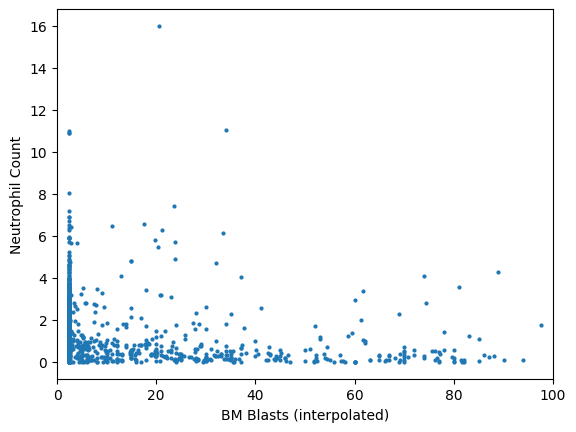

In [73]:
plt.scatter(merged_h2_data.bm_blasts_interpolated, merged_h2_data.b_neut, s=4)
plt.xlim(0, 100)
plt.xlabel('BM Blasts (interpolated)')
plt.ylabel('Neutrophil Count')

In [74]:
scipy.stats.spearmanr(merged_h2_data.b_neut, merged_h2_data.bm_blasts_interpolated)

SignificanceResult(statistic=-0.3522609104459314, pvalue=9.930152605959012e-49)

### Aggregated Neutrophil vs time-since-treatment (H1)

In [75]:
merged_h1_data = pd.concat(neut_treatment_matched.values())

Text(0, 0.5, 'Neutrophil Count')

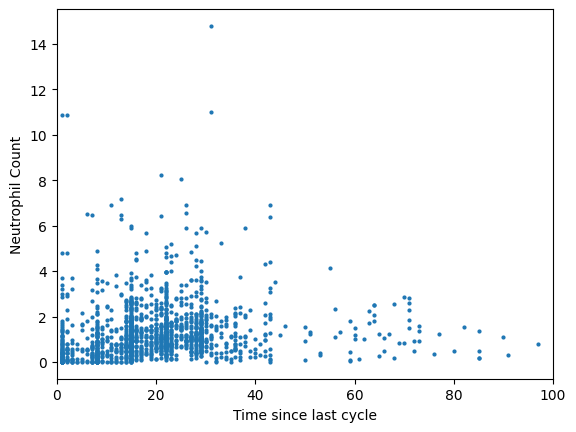

In [76]:
plt.scatter(merged_h1_data.time_after_cycle, merged_h1_data.b_neut, s=4)
plt.xlim(0, 100)
plt.xlabel('Time since last cycle')
plt.ylabel('Neutrophil Count')

In [77]:
scipy.stats.spearmanr(merged_h1_data.b_neut, merged_h1_data.time_after_cycle)

SignificanceResult(statistic=0.22976415205716752, pvalue=7.320952965801284e-20)

## Crosstabs and statistics

TODO: merging correlations data with patient data

### Summary Statistics of the Hypotheses

In [78]:
# H1 & H2
corr_df.query('neut_treatment_spearmanr > 0 and neut_blast_spearmanr < 0').shape

(39, 10)

In [79]:
# H1 & ~H2
corr_df.query('neut_treatment_spearmanr > 0 and neut_blast_spearmanr >= 0').shape

(17, 10)

In [80]:
# ~H1 & H2
corr_df.query('neut_treatment_spearmanr <= 0 and neut_blast_spearmanr < 0').shape

(16, 10)

In [81]:
# ~H1 & ~H2
corr_df.query('neut_treatment_spearmanr <= 0 and neut_blast_spearmanr >= 0').shape

(6, 10)

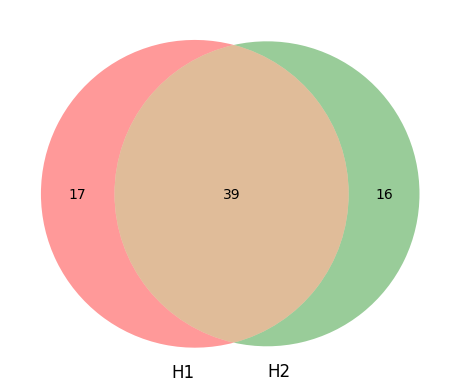

In [82]:
### venn diagrams
from matplotlib_venn import venn2
venn2(subsets=(17, 16, 39), set_labels=['H1', 'H2'])

What about high-resolution patients?

In [83]:
# H1 & H2

corr_df.query('neut_treatment_spearmanr > 0 and neut_blast_spearmanr < 0 and neut_count >= 20').shape

(19, 10)

In [84]:
# ~H1 & H2

corr_df.query('neut_treatment_spearmanr < 0 and neut_blast_spearmanr < 0 and neut_count >= 20').shape

(7, 10)

In [85]:
# H1 & ~H2

corr_df.query('neut_treatment_spearmanr > 0 and neut_blast_spearmanr > 0 and neut_count >= 20').shape

(3, 10)

In [86]:
# ~H1 & ~H2

corr_df.query('neut_treatment_spearmanr <= 0 and neut_blast_spearmanr >= 0 and neut_count >= 20').shape

(1, 10)

Text(0.5, 1.0, 'High-resolution dataset')

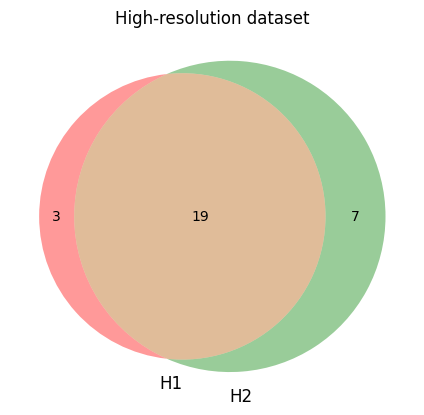

In [87]:
venn2(subsets=(3, 7, 19), set_labels=['H1', 'H2'])
plt.title('High-resolution dataset')

In [88]:
corr_df.neut_treatment_spearmanr.describe()

count    80.000000
mean      0.227038
std       0.458008
min      -1.000000
25%      -0.008261
50%       0.236089
75%       0.519983
max       1.000000
Name: neut_treatment_spearmanr, dtype: float64

In [89]:
corr_df.neut_blast_spearmanr.describe()

count    78.000000
mean     -0.165473
std       0.324993
min      -0.857373
25%      -0.399336
50%      -0.197506
75%       0.022400
max       0.564288
Name: neut_blast_spearmanr, dtype: float64

<Axes: >

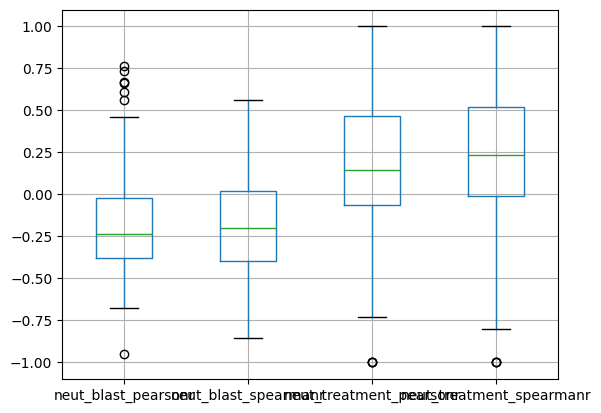

In [90]:
corr_df[['neut_blast_pearsonr',
         'neut_blast_spearmanr',
         'neut_treatment_pearsonr',
         'neut_treatment_spearmanr',]].boxplot()

<Axes: >

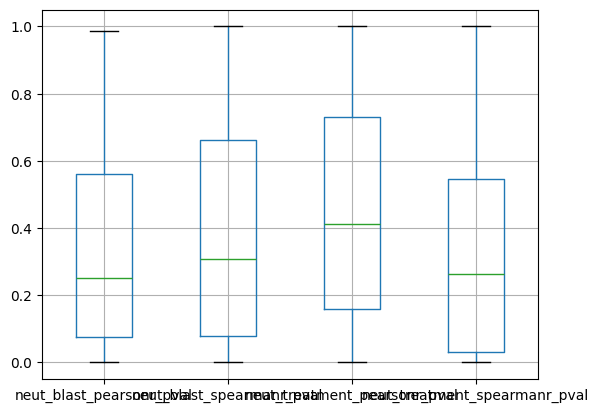

In [91]:
corr_df[['neut_blast_pearsonr_pval',
         'neut_blast_spearmanr_pval',
         'neut_treatment_pearsonr_pval',
         'neut_treatment_spearmanr_pval']].boxplot()

### Loading patient data

In [92]:
patient_data = pd.read_csv('../patient_data_venex/ven_responses_052023.txt', sep='\t')
patient_data.index = patient_data.Study_subject_Id
corr_df.index = corr_df.pid
merged_data = corr_df.join(patient_data)

In [93]:
merged_data['h1'] = merged_data.neut_treatment_spearmanr > 0

In [94]:
merged_data['h2'] = merged_data.neut_blast_spearmanr < 0

### Contingency tables - H1 and H2 vs outcomes

#### H1 vs H2

In [95]:
pd.crosstab(merged_data.h1, merged_data.h2)

h2,False,True
h1,,
False,6,16
True,19,39


In [96]:
scipy.stats.chi2_contingency(pd.crosstab(merged_data.h1, merged_data.h2))

Chi2ContingencyResult(statistic=0.041037332573382726, pvalue=0.8394658776500095, dof=1, expected_freq=array([[ 6.875, 15.125],
       [18.125, 39.875]]))

This indicates that there is no significant association between H1 and H2.

In [97]:
pd.crosstab(merged_data.best_response, merged_data.relapse_occurred)

relapse_occurred,No,Yes
best_response,,
CR,23,18
CRh,0,2
CRi,3,11
MLFS,4,8
PR/SD/PD/RD,11,0


In [98]:
scipy.stats.chi2_contingency(pd.crosstab(merged_data.best_response, merged_data.relapse_occurred))

Chi2ContingencyResult(statistic=19.47669093415673, pvalue=0.0006333265176064788, dof=4, expected_freq=array([[21.0125, 19.9875],
       [ 1.025 ,  0.975 ],
       [ 7.175 ,  6.825 ],
       [ 6.15  ,  5.85  ],
       [ 5.6375,  5.3625]]))

#### H1 vs best_response

In [99]:
pd.crosstab(merged_data.best_response, merged_data.h1)

h1,False,True
best_response,,
CR,11,30
CRh,1,1
CRi,3,11
MLFS,2,10
PR/SD/PD/RD,5,6


In [100]:
scipy.stats.chi2_contingency(pd.crosstab(merged_data.best_response, merged_data.h1))

Chi2ContingencyResult(statistic=3.26087654476675, pvalue=0.5151548228597873, dof=4, expected_freq=array([[11.275, 29.725],
       [ 0.55 ,  1.45 ],
       [ 3.85 , 10.15 ],
       [ 3.3  ,  8.7  ],
       [ 3.025,  7.975]]))

#### H1 vs relapse_occurred, status

In [101]:
pd.crosstab(merged_data.relapse_occurred, merged_data.h1)

h1,False,True
relapse_occurred,,
No,11,30
Yes,11,28


In [102]:
pd.crosstab(merged_data.status, merged_data.h1)

h1,False,True
status,,
Alive,7,24
Exitus,15,34


In [103]:
scipy.stats.chi2_contingency(pd.crosstab(merged_data.status, merged_data.h1))

Chi2ContingencyResult(statistic=0.2775295576821081, pvalue=0.5983250226566638, dof=1, expected_freq=array([[ 8.525, 22.475],
       [13.475, 35.525]]))

Assumption 1 is not significantly associated with best_response, relapse, or status.

#### H2 vs best_response

In [104]:
pd.crosstab(merged_data.best_response, merged_data.h2)

h2,False,True
best_response,,
CR,4,37
CRh,2,0
CRi,5,9
MLFS,7,5
PR/SD/PD/RD,7,4


In [105]:
scipy.stats.chi2_contingency(pd.crosstab(merged_data.best_response, merged_data.h2))

Chi2ContingencyResult(statistic=22.813495742985765, pvalue=0.00013796543658435508, dof=4, expected_freq=array([[12.8125, 28.1875],
       [ 0.625 ,  1.375 ],
       [ 4.375 ,  9.625 ],
       [ 3.75  ,  8.25  ],
       [ 3.4375,  7.5625]]))

This is a significant result!!!

#### H2 vs relapse_occurred, status

In [106]:
pd.crosstab(merged_data.relapse_occurred, merged_data.h2)

h2,False,True
relapse_occurred,,
No,14,27
Yes,11,28


In [107]:
scipy.stats.chi2_contingency(pd.crosstab(merged_data.relapse_occurred, merged_data.h2))

Chi2ContingencyResult(statistic=0.11006879299562225, pvalue=0.740065829560373, dof=1, expected_freq=array([[12.8125, 28.1875],
       [12.1875, 26.8125]]))

In [108]:
pd.crosstab(merged_data.status, merged_data.h2)

h2,False,True
status,,
Alive,7,24
Exitus,18,31


In [109]:
scipy.stats.chi2_contingency(pd.crosstab(merged_data.status, merged_data.h2))

Chi2ContingencyResult(statistic=1.1730205278592376, pvalue=0.278781471518633, dof=1, expected_freq=array([[ 9.6875, 21.3125],
       [15.3125, 33.6875]]))

### Hypotheses and clinical variables

#### H1 & gender, age, prev AML, FAB, ECOG

In [110]:
pd.crosstab(merged_data.Gender, merged_data.h1)

h1,False,True
Gender,,
Female,7,28
Male,15,30


In [111]:
scipy.stats.chi2_contingency(pd.crosstab(merged_data.Gender, merged_data.h1))

Chi2ContingencyResult(statistic=1.1504204607652881, pvalue=0.2834611497640769, dof=1, expected_freq=array([[ 9.625, 25.375],
       [12.375, 32.625]]))

In [112]:
pd.crosstab(merged_data.age_group_scr, merged_data.h1)

h1,False,True
age_group_scr,,
75 years or younger,15,36
>75 years,7,22


In [113]:
scipy.stats.chi2_contingency(pd.crosstab(merged_data.age_group_scr, merged_data.h1))

Chi2ContingencyResult(statistic=0.061212248384382426, pvalue=0.8045900908978876, dof=1, expected_freq=array([[14.025, 36.975],
       [ 7.975, 21.025]]))

In [114]:
pd.crosstab(merged_data.incl_dg_for_tables, merged_data.h1)

h1,False,True
incl_dg_for_tables,,
De novo / ND AML,13,30
R/R AML,5,21
sAML,4,7


In [115]:
scipy.stats.chi2_contingency(pd.crosstab(merged_data.incl_dg_for_tables, merged_data.h1))

Chi2ContingencyResult(statistic=1.4862268299608827, pvalue=0.4756307719278672, dof=2, expected_freq=array([[11.825, 31.175],
       [ 7.15 , 18.85 ],
       [ 3.025,  7.975]]))

In [116]:
pd.crosstab(merged_data.fab, merged_data.h1)

h1,False,True
fab,,
#NULL!,1,3
M0,1,5
M1,7,15
M2,6,12
M4,1,1
M5,0,9
Not known,6,9
sAML (FAB not known),0,3
tAML (FAB not known),0,1


In [117]:
scipy.stats.chi2_contingency(pd.crosstab(merged_data.fab, merged_data.h1))

Chi2ContingencyResult(statistic=7.493112947658402, pvalue=0.48447939961366937, dof=8, expected_freq=array([[ 1.1  ,  2.9  ],
       [ 1.65 ,  4.35 ],
       [ 6.05 , 15.95 ],
       [ 4.95 , 13.05 ],
       [ 0.55 ,  1.45 ],
       [ 2.475,  6.525],
       [ 4.125, 10.875],
       [ 0.825,  2.175],
       [ 0.275,  0.725]]))

In [118]:
pd.crosstab(merged_data.ecog_scr, merged_data.h1)

h1,False,True
ecog_scr,,
0,7,14
1,9,33
2,4,11
3,2,0


In [119]:
scipy.stats.chi2_contingency(pd.crosstab(merged_data.ecog_scr, merged_data.h1))

Chi2ContingencyResult(statistic=6.412897447380206, pvalue=0.09316163852896445, dof=3, expected_freq=array([[ 5.775, 15.225],
       [11.55 , 30.45 ],
       [ 4.125, 10.875],
       [ 0.55 ,  1.45 ]]))

H1 is not associated with a single clinical variable.

#### H2 & gender, age, prev AML, FAB, ECOG

In [120]:
pd.crosstab(merged_data.Gender, merged_data.h2)

h2,False,True
Gender,,
Female,9,26
Male,16,29


In [121]:
scipy.stats.chi2_contingency(pd.crosstab(merged_data.Gender, merged_data.h2))

Chi2ContingencyResult(statistic=0.4885425685425685, pvalue=0.4845781524858668, dof=1, expected_freq=array([[10.9375, 24.0625],
       [14.0625, 30.9375]]))

In [122]:
pd.crosstab(merged_data.age_group_scr, merged_data.h2)

h2,False,True
age_group_scr,,
75 years or younger,18,33
>75 years,7,22


In [123]:
scipy.stats.chi2_contingency(pd.crosstab(merged_data.age_group_scr, merged_data.h2))

Chi2ContingencyResult(statistic=0.6146659290675518, pvalue=0.43303639470835653, dof=1, expected_freq=array([[15.9375, 35.0625],
       [ 9.0625, 19.9375]]))

In [124]:
pd.crosstab(merged_data.incl_dg_for_tables, merged_data.h2)

h2,False,True
incl_dg_for_tables,,
De novo / ND AML,8,35
R/R AML,11,15
sAML,6,5


In [125]:
scipy.stats.chi2_contingency(pd.crosstab(merged_data.incl_dg_for_tables, merged_data.h2))

Chi2ContingencyResult(statistic=7.458655509395467, pvalue=0.02400897033044965, dof=2, expected_freq=array([[13.4375, 29.5625],
       [ 8.125 , 17.875 ],
       [ 3.4375,  7.5625]]))

In [126]:
pd.crosstab(merged_data.fab, merged_data.h2)

h2,False,True
fab,,
#NULL!,3,1
M0,2,4
M1,4,18
M2,6,12
M4,2,0
M5,3,6
Not known,2,13
sAML (FAB not known),3,0
tAML (FAB not known),0,1


In [127]:
scipy.stats.chi2_contingency(pd.crosstab(merged_data.fab, merged_data.h2))

Chi2ContingencyResult(statistic=19.074820936639117, pvalue=0.01446458550753756, dof=8, expected_freq=array([[ 1.25  ,  2.75  ],
       [ 1.875 ,  4.125 ],
       [ 6.875 , 15.125 ],
       [ 5.625 , 12.375 ],
       [ 0.625 ,  1.375 ],
       [ 2.8125,  6.1875],
       [ 4.6875, 10.3125],
       [ 0.9375,  2.0625],
       [ 0.3125,  0.6875]]))

In [128]:
pd.crosstab(merged_data.ecog_scr, merged_data.h2)

h2,False,True
ecog_scr,,
0,7,14
1,14,28
2,3,12
3,1,1


In [129]:
scipy.stats.chi2_contingency(pd.crosstab(merged_data.ecog_scr, merged_data.h2))

Chi2ContingencyResult(statistic=1.3381818181818181, pvalue=0.7200870074397472, dof=3, expected_freq=array([[ 6.5625, 14.4375],
       [13.125 , 28.875 ],
       [ 4.6875, 10.3125],
       [ 0.625 ,  1.375 ]]))

### Continuous statistics (using correlations)

#### H1 vs outcome variables

<Axes: title={'center': 'neut_treatment_spearmanr'}, xlabel='best_response'>

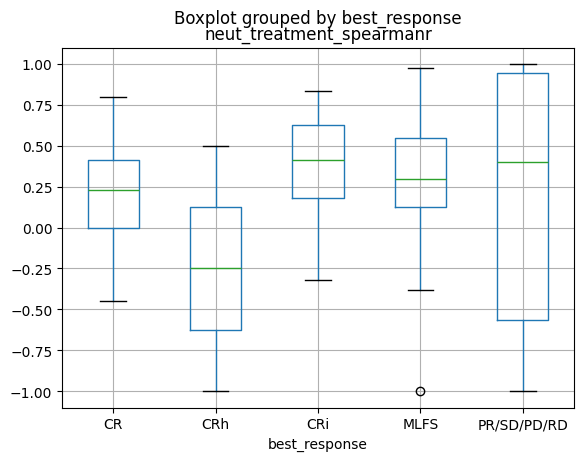

In [130]:
merged_data.boxplot(column='neut_treatment_spearmanr', by='best_response')

<Axes: title={'center': 'neut_treatment_spearmanr'}, xlabel='status'>

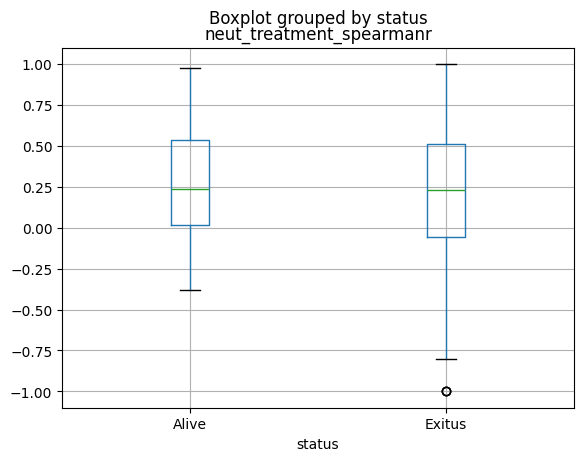

In [131]:
merged_data.boxplot(column='neut_treatment_spearmanr', by='status')

#### H1 vs a priori variables

<Axes: title={'center': 'neut_treatment_spearmanr'}, xlabel='incl_dg_for_tables'>

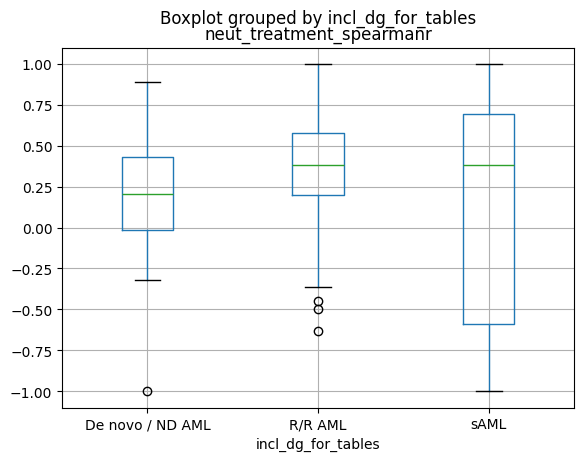

In [132]:
merged_data.boxplot(column='neut_treatment_spearmanr', by='incl_dg_for_tables')

<Axes: title={'center': 'neut_treatment_spearmanr'}, xlabel='ecog_scr'>

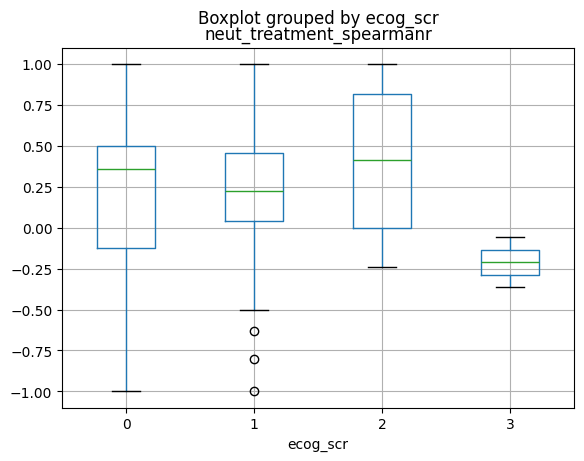

In [133]:
merged_data.boxplot(column='neut_treatment_spearmanr', by='ecog_scr')

<Axes: title={'center': 'neut_treatment_spearmanr'}, xlabel='fab'>

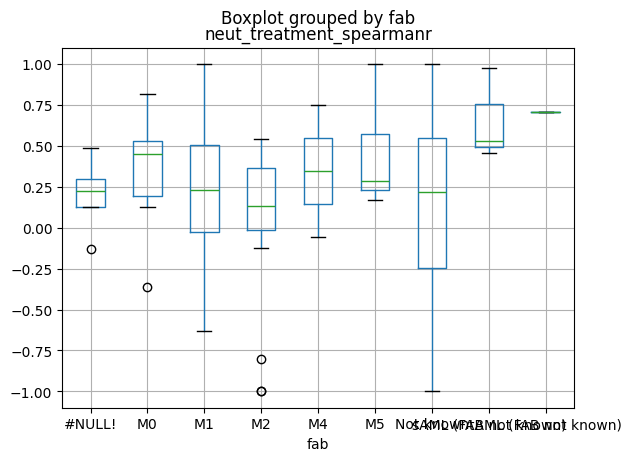

In [134]:
merged_data.boxplot(column='neut_treatment_spearmanr', by='fab')

#### H2 vs outcome variables

<Axes: title={'center': 'neut_blast_spearmanr'}, xlabel='best_response'>

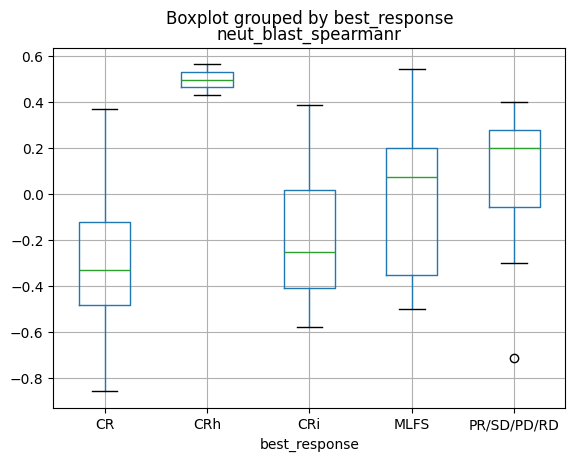

In [135]:
merged_data.boxplot(column='neut_blast_spearmanr', by='best_response')

<Axes: title={'center': 'neut_blast_spearmanr'}, xlabel='status'>

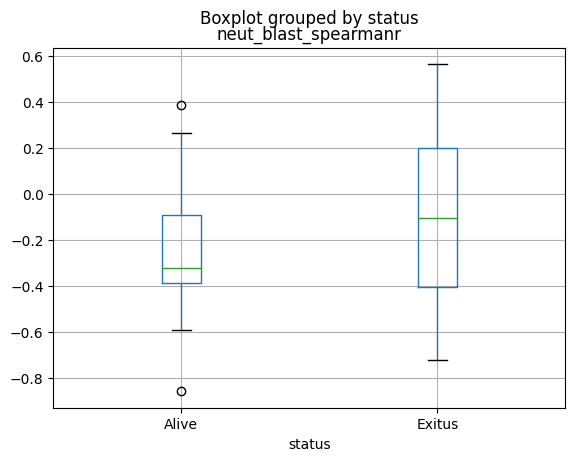

In [136]:
merged_data.boxplot(column='neut_blast_spearmanr', by='status')

#### H2 vs a priori variables

<Axes: title={'center': 'neut_blast_spearmanr'}, xlabel='incl_dg_for_tables'>

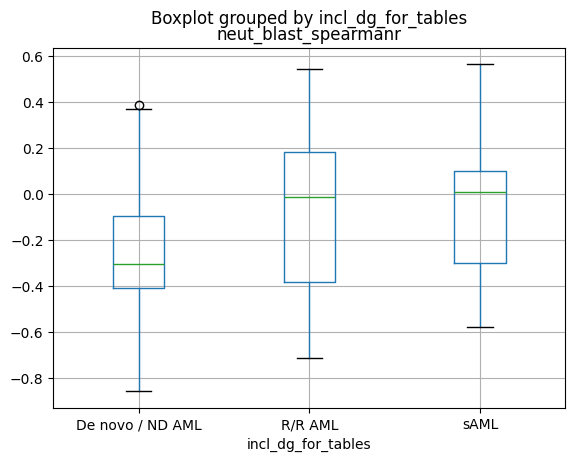

In [137]:
merged_data.boxplot(column='neut_blast_spearmanr', by='incl_dg_for_tables')

<Axes: title={'center': 'neut_blast_spearmanr'}, xlabel='ecog_scr'>

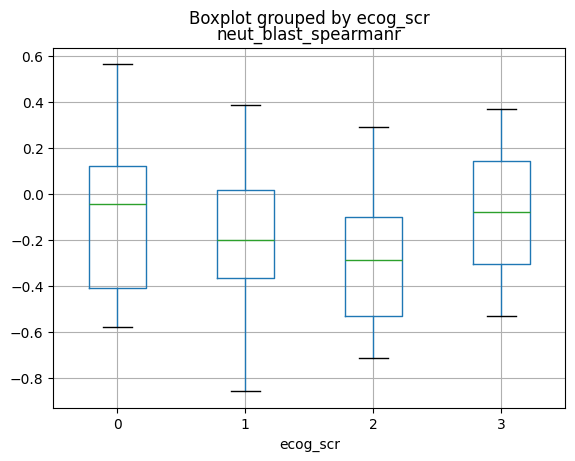

In [138]:
merged_data.boxplot(column='neut_blast_spearmanr', by='ecog_scr')

<Axes: title={'center': 'neut_blast_spearmanr'}, xlabel='fab'>

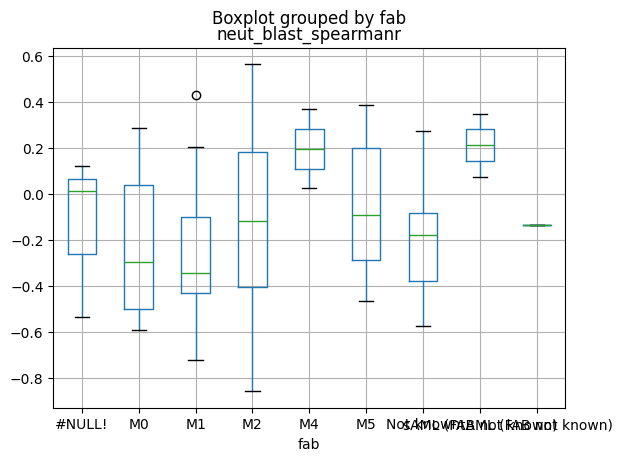

In [139]:
merged_data.boxplot(column='neut_blast_spearmanr', by='fab')